In [165]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [206]:
from IPython.display import Markdown, HTML

In [167]:
import numpy as np

In [168]:
import matplotlib.pyplot as plt

In [169]:
import seaborn as sns

In [170]:
import geojson
import plotly.express as px
import plotly.graph_objects as go

# <p style = 'text-align:center'> Fonctions </p>

## Features engineering fonctions

In [171]:
def features_choices_15(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench['lat']=bench['loc'].apply(lambda r:r.split('\'')[3]).astype('float')
    bench['lon']=bench['loc'].apply(lambda r:r.split('\'')[7]).astype('float')
    bench['adress']=bench['loc'].apply(lambda r:r.split('\'')[11].split(',')[0].split("\"")[3])
    bench = bench.drop(columns=['loc'])
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [172]:
def features_choices_16(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [173]:
def features_choices(bench15_1, bench16_1, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var):
    bench15_info, bench15_model = features_choices_15(bench15_1, to_drop_15, new_names_15, info_var, model_var)
    bench16_info, bench16_model = features_choices_16(bench16_1, to_drop_16, new_names_16, info_var, model_var)
    bench_info = pd.concat([bench15_info, bench16_info],axis=0).reset_index(drop=True)
#     bench_info = bench_info.drop_duplicates(subset = ["id"]).reset_index(drop=True)
    bench_model = pd.concat([bench15_model, bench16_model],axis=0).reset_index(drop=True)
#     bench_model = bench_model.drop_duplicates(subset = ["id"]).reset_index(drop=True) 
    return bench_info, bench_model

In [174]:
def loc_outlier():
    # from sklearn.neighbors import LocalOutlierFactor
    # X = bench_model_cleaned[['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'tput_gfa', 'energy_use', 'ghg_emission']].values
    # clf = LocalOutlierFactor(n_neighbors=3)
    # a = pd.DataFrame(data=clf.fit_predict(X),columns=['outlier'])
    # a['id']=bench_model_cleaned.id
    # a.outlier.value_counts()
    # bench_model_cleaned = bench_model_cleaned.drop(bench_model_cleaned[bench_model_cleaned.id.isin(a[a['outlier']==-1]['id'].values)].index)
    # clf.negative_outlier_factor_
    return 3

## Cleaning function

In [175]:
def outlier_cleaning(bench,outliers_id):
    bench_no_outlier = bench.drop(bench[bench['id'].isin(outliers_id)].index)
    #(bench_no_outlier['SiteEnergyUse(kBtu)']>=2*10**7)|
    outliers_idx = bench_no_outlier[(bench_no_outlier['energy_use']<=10**4)|(bench_no_outlier.energy_use > 25118864)|(bench_no_outlier.ghg_emission < 1)].index
    bench_no_outlier = bench_no_outlier.drop(outliers_idx)
    return bench_no_outlier

In [176]:
def property_use_types_cleansing_and_imputation(bench_model):
    # Imputation de la variable largest property use type avec la variable primary property type
    unchanged = ["Hotel","Retail Store","Non-Refrigerated Warehouse","Other","Distribution Center","Medical Office","Worship Facility","Laboratory","Refrigerated Warehouse","Supermarket/Grocery Store", "Restaurant", "College/University","Senior Care Community","Self-Storage Facility"]
    for idx in bench_model[(~bench_model["primary_type"].isna())&(bench_model["lput"].isna())].index:
        if (bench_model.loc[idx,"primary_type"]=="Large Office")|(bench_model.loc[idx,"primary_type"]=="Small- and Mid-Sized Office"):
            bench_model.at[idx,"lput"] = "Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]    
        if "Multifamily" in bench_model.loc[idx,"primary_type"]:
            bench_model.at[idx,"lput"] = "Multifamily Housing"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if (bench_model.loc[idx,"primary_type"]=="SPS-District K-12"):
            bench_model.at[idx,"lput"] = "K-12 School"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 
        if (bench_model.loc[idx,"primary_type"]=="Hospital"):
            bench_model.at[idx,"lput"] = "Hospital (General Medical & Surgical)"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx in [649, 2262, 2716]:
            bench_model.at[idx,"lput"] = "Retail Store"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==347:
            bench_model.at[idx,"lput"] = "Medical Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==309:
            bench_model.at[idx,"lput"] = "Other"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if bench_model.loc[idx,"primary_type"] in unchanged:
            bench_model.at[idx,"lput"] = bench_model.loc[idx,"primary_type"]
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]

    # Imputation des second et third property use type
    to_complete_cat = ['lput', 'sput', 'tput']
    for cat in to_complete_cat:
        bench_model[cat] = bench_model[cat].fillna('Aucun')
        bench_model[cat+'_gfa'] = bench_model[cat+'_gfa'].fillna(0)
    
    # Suppression des données non utilisables 
    drop_idx_1 = bench_model[(bench_model['energy_use'].isna())|(bench_model['ghg_emission'].isna())].index
    bench_model = bench_model.drop(drop_idx_1)
    # Suppression des propriétés dont on ne connais pas le nombre d'étage
    drop_idx_2 = bench_model[(bench_model["nf"].isna())].index
    bench_model = bench_model.drop(drop_idx_2)
    # Regroupement de la classe NonResidential
    bench_model['type']=bench_model['type'].replace('Nonresidential COS','NonResidential')
    # Reset de l'index
    bench_model = bench_model.reset_index(drop=True)
    
    return bench_model

## Data Visualisation Functions

In [177]:
def boxplot(x):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.boxplot(x, vert = False)
    plt.show()

In [178]:
def barplot(x, y, data):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.set_theme(style="whitegrid") 
    ax = sns.barplot(x=x, y=y, data=data)
    plt.show()

In [179]:
def seattle_map():
    f = open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2016_seattle_city.geojson", "r")
    dep_gjs=geojson.load(f)
    scl = [[0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]]
    fig = px.choropleth(pd.DataFrame([[1,2],[1,2]],columns=['CD','color']), geojson=dep_gjs, color="color",locations="CD", featureidkey="properties.rowID",projection="mercator",color_continuous_scale=["#ffffff","#eeeeee"])
    fig.update_layout(coloraxis_showscale=False)
    fig.add_traces(go.Scattergeo(lat=bench_info.lat, lon=bench_info.lon, text=bench_model["id"].astype('str')+' : '+bench_model["energy_use"].astype('str'),marker = dict(size = 3,color = bench_model['energy_use'],colorscale = scl, colorbar = dict(titleside = "right", outlinecolor = "rgba(68, 68, 68, 0)"))))
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":20,"l":0,"b":20})
    fig.show()

In [180]:
def histogram(data, x):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.set_theme(style="whitegrid") 
    sns.histplot(data=data, x=x)
    plt.show()

# <p style = 'text-align:center'> Importation des données </p>

In [181]:
bench15_0, bench16_0 = pd.read_csv(r"2015-building-energy-benchmarking.csv"), pd.read_csv(r"2016-building-energy-benchmarking.csv")

In [182]:
outliers_id = np.concatenate((bench15_0[~bench15_0.Outlier.isna()].OSEBuildingID.values,bench16_0[~bench16_0.Outlier.isna()].OSEBuildingID.values))

# <p style = 'text-align:center'> Choix des features </p>

In [183]:
# import json
# file=open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\socrata_metadata_2015-building-energy-benchmarking.json")
# meta_2015=json.load(file)
# file_2=open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\socrata_metadata_2016-building-energy-benchmarking.json")
# meta_2016=json.load(file_2)

In [184]:
# display(Markdown('# <p style=\'text-align:center\'> Description des variables : </p>'))
# for i in range(len(meta_2015["columns"])):
#     try:
#         print('\033[1m' + meta_2015["columns"][i]["name"] + '\033[0m' + ' : ' + meta_2015["columns"][i]["description"]+'\n')
#     except:
#         continue

In [185]:
# features à supprimer dans le dataset de 2015 et celui de 2016
to_drop_15 = ["DataYear","YearBuilt",'TaxParcelIdentificationNumber', 'Neighborhood','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)',  'NaturalGas(therms)', 'OtherFuelUse(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)','DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats']
to_drop_16 = ['DataYear', 'City', 'State', 'TaxParcelIdentificationNumber', 'Neighborhood', 'YearBuilt', 'ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']

# nouveaux noms pour les features qu'on garde dans le dataset de 2015 et 2016 
new_names_15 = {'OSEBuildingID':'id', 'CouncilDistrictCode':'district_code' , 'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name','Location':'loc', 'NumberofBuildings':'nb', 'NumberofFloors':'nf','PropertyGFATotal':'total_gfa',  'PropertyGFAParking':'parking_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'GHGEmissions(MetricTonsCO2e)':'ghg_emission', 'Zip Codes':'zip', 'SteamUse(kBtu)':'steam', 'Electricity(kBtu)':'electricity', 'NaturalGas(kBtu)':'natural_gas'}
new_names_16 = {'OSEBuildingID':'id', 'CouncilDistrictCode':'district_code' ,'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name', 'Address':'adress', 'ZipCode':'zip', 'Latitude':'lat', 'Longitude':'lon', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFAParking':'parking_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'TotalGHGEmissions':'ghg_emission', 'SteamUse(kBtu)':'steam', 'Electricity(kBtu)':'electricity', 'NaturalGas(kBtu)':'natural_gas'}

In [186]:
# features pour le dataset des informations des propriétés
info_var = ['id', 'name', 'lat', 'lon', 'adress', 'energy_score', 'zip']

#features pour le dataset des variables du modèle
model_var = ['id', 'age', 'nb', 'nf', 'type', 'primary_type','district_code', 'building_gfa' ,'parking_gfa','total_gfa', 'lput', 'lput_gfa', 'sput', 'sput_gfa', 'tput', 'tput_gfa', 'energy_score', 'energy_use', 'ghg_emission','electricity','natural_gas','steam']

In [187]:
bench_info, bench_model = features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var)

# <p style = 'text-align:center'> Exploration des features </p>

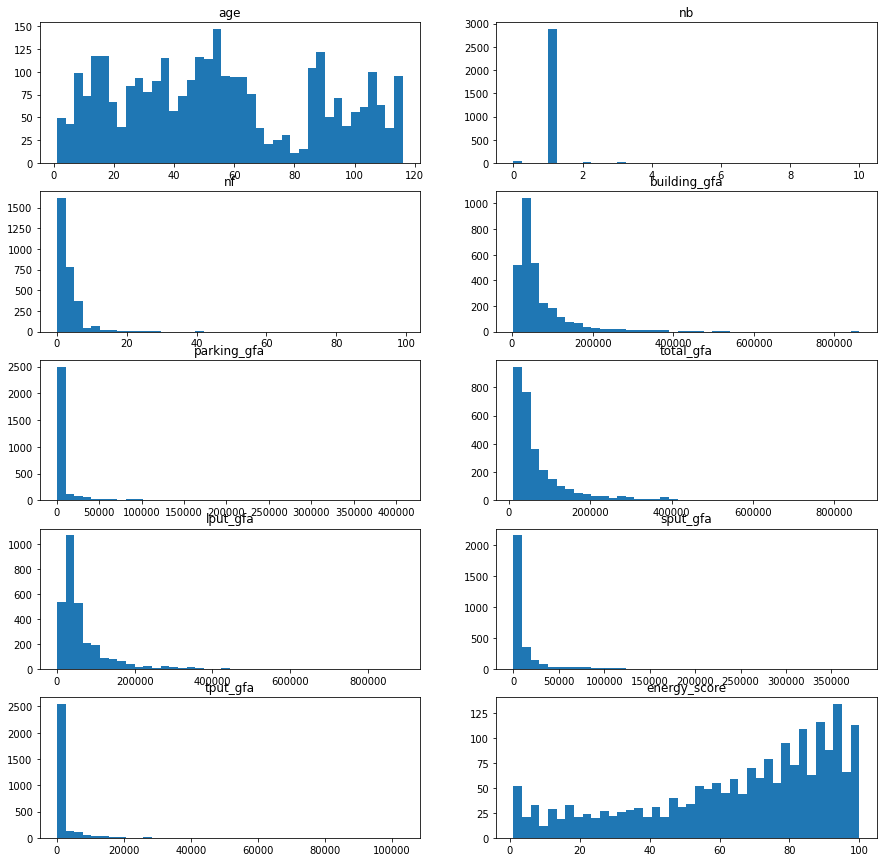

In [210]:
fig, axs = plt.subplots(5,2, figsize=(15,15))
numerical_features = ['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'tput_gfa', 'energy_score']
for idx in range(len(numerical_features)):
    axs[idx//2,idx%2].hist(bench_model[numerical_features[idx]],bins=40)
    axs[idx//2,idx%2].set_title(numerical_features[idx])

##  Corrélations

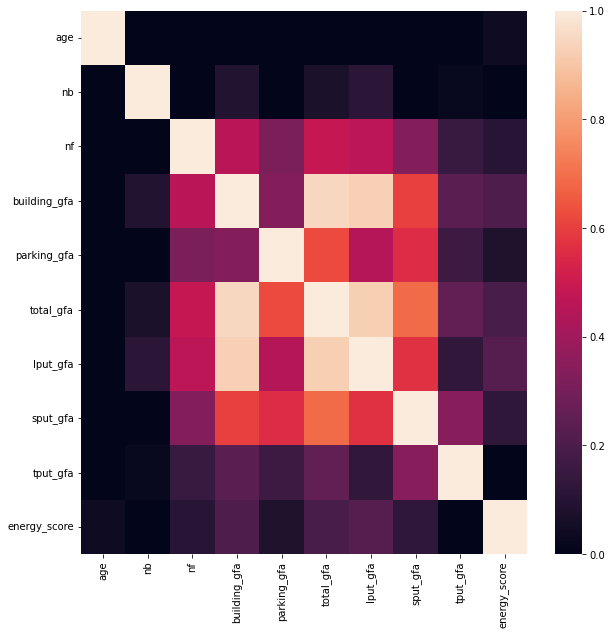

In [208]:
numerical_features = ['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'tput_gfa', 'energy_score']
bench_model_num = bench_model[numerical_features]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(bench_model_num.corr(), vmin=0, vmax=1)
plt.show()

# <p style = 'text-align:center'> Bâtiments non destinés à l'habitation </p>

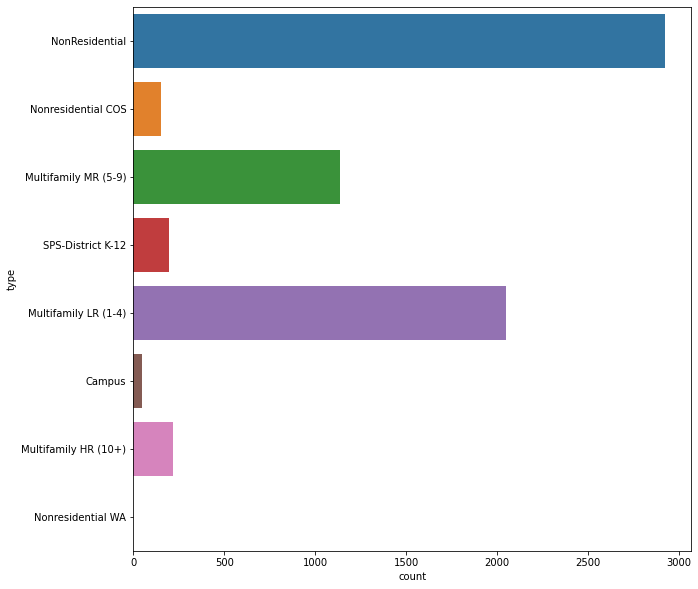

In [189]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(y=bench_model.type)

In [190]:
bench_model = bench_model.drop(bench_model[bench_model['type'].str.contains('Multifamily')].index)

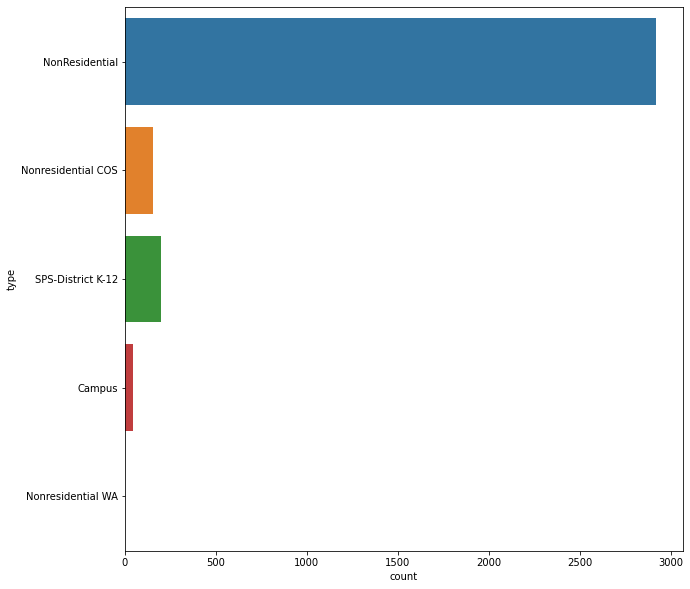

In [191]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(y=bench_model.type)

# <p style = 'text-align:center'> Nettoyage des outliers </p>

In [192]:
# Suppression des outliers
bench_model = outlier_cleaning(bench_model,outliers_id)

# <p style = 'text-align:center'> Création de nouvelles features </p>

In [193]:
bench_model['electricity_bool'] = bench_model['electricity'].apply(lambda x : 1 if x!=0 else 0)
bench_model['electricity_pct'] = bench_model['electricity'].divide(bench_model['energy_use'])
bench_model['natural_gas_bool'] = bench_model['natural_gas'].apply(lambda x : 1 if x!=0 else 0)
bench_model['natural_gas_pct'] = bench_model['natural_gas'].divide(bench_model['energy_use'])
bench_model['steam_bool'] = bench_model['steam'].apply(lambda x : 1 if x!=0 else 0)
bench_model['steam_pct'] = bench_model['steam'].divide(bench_model['energy_use'])
bench_model = bench_model.drop(columns=['electricity','natural_gas','steam'])

# <p style = 'text-align:center'> Valeurs abbérentes </p>

In [194]:
# Propriétés ayant des surfaces négatives 
negativ_area_index = bench_model[(bench_model["total_gfa"]<0)|(bench_model["building_gfa"]<0)|(bench_model["parking_gfa"]<0)].index
for idx in negativ_area_index:
    bench_model.at[idx,"building_gfa"] = np.abs(bench_model.at[idx,"building_gfa"])
    bench_model.at[idx,"parking_gfa"] = np.abs(bench_model.at[idx,"parking_gfa"])
    bench_model.at[idx,"total_gfa"] = np.abs(bench_model.at[idx,"total_gfa"])

In [195]:
# Valeurs abbérentes détecté manuellement
bench_model = bench_model.drop(bench_model[(bench_model.id.isin([33, 34, 54, 60, 61, 70, 85, 100, 102, 113, 230, 49784, 553]))].index)

# <p style = 'text-align:center'> Imputations </p>

In [196]:
bench_model_cleaned = property_use_types_cleansing_and_imputation(bench_model)

In [197]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Xnum = bench_model_cleaned[['age','nb','nf','building_gfa','parking_gfa','lput_gfa','sput_gfa','tput_gfa','energy_score']].values
Xcat = bench_model_cleaned[['type','district_code','lput','sput','tput']]
enc = OneHotEncoder(handle_unknown='ignore')
Xenc = enc.fit_transform(Xcat.values).toarray()
X = np.concatenate((Xnum, Xenc),axis=1)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
X_imp = imputer.fit_transform(X)

bench_model_cleaned['energy_score'] = X_imp[:,8]

In [201]:
# bench_model_cleaned.info()

In [199]:
# boxplot(bench_model_cleaned['energy_use'])

In [200]:
# seattle_map()

In [237]:
bench_model_cleaned.to_excel("benchmark_cleaned.xlsx", index=False)

In [39]:
# R = bench.energy_use
# s = bench.ghg_emission
# R_train, R_test, s_train, s_test = train_test_split(R, s, test_size=0.2, random_state=80)
# scaler = StandardScaler()
# scaler.fit([[x] for x in R_train])
# R_train_std =scaler.transform([[x] for x in R_train])
# R_test_std = scaler.transform([[x] for x in R_test])

# ridge = Ridge(alpha = 10000)
# ridge.fit(R_train_std, s_train)
# s_pred_train_simple, s_pred_test_simple  = ridge.predict(R_train_std), ridge.predict(R_test_std)

# time_simple= get_time(start_time, end_time)

# show_metric(s_pred_train_simple, s_train, s_pred_test_simple, s_test, time_simple)

In [126]:
# model_vs_real(s_pred_train_simple, s_train, 'ghg_emission')